# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2
import tensorflow as tf

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
#print (X_train.shape)
n_train = 39209

# TODO: Number of testing examples.
#print (X_test.shape)
n_test = 12630

# TODO: What's the shape of an traffic sign image?
#print (X_train.shape)
image_shape = (32,32)

# TODO: How many unique classes/labels there are in the dataset.
#print (set(y_train))
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

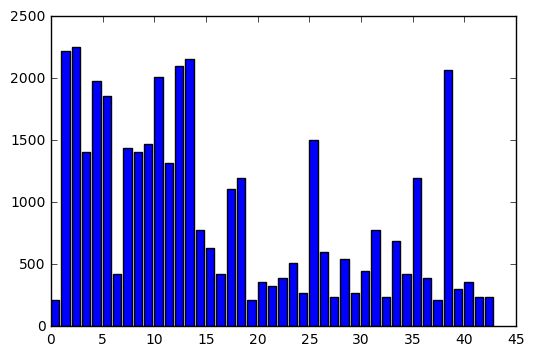

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Count of occurences for each label in the training dataset
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.show()

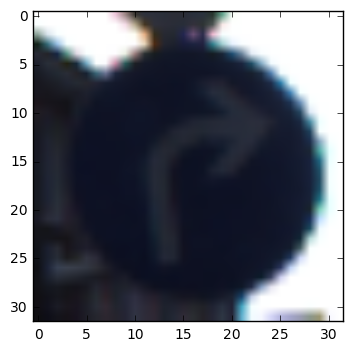

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#Visualization of particular images
#img = X_train[18020,:,:,:] #check image of particular sign /Yellow sign
#img = X_train[1000,:,:,:] #check image of particular sign /Red sign
#img = X_train[34000,:,:,:] #check image of particular sign /Blue sign
#img = X_train[28300,:,:,:] #check image of particular sign /Yellow sign
img = X_train[33500,:,:,:] #check image of particular sign /Blue sign
plt.imshow(img)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
# Implementation of feature pre-processing, to convert to color channels of 'interest'
def imgConv(img):
    blue = img[:,:,0]
    red = img[:,:,2]
    # gray_image channel was replaced with CLAHE, that gave better results
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #gray
    # Yellow channel, removed before final testing
    # lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab) #yellow
    # yellow = lab[:,:,2]

    # create clahe Contrast-limited Adaptive Histogram Equalization
    # improve grayscale (idea based on http://people.idsia.ch/~juergen/ijcnn2011.pdf)
    claheObj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    clahe = claheObj.apply(gray_image)
    stacked = np.stack((blue,red,clahe),axis=2)
    return stacked

In [6]:
# Implementation of label conversion to one hot encoding
def oneHot(label):
    vec = np.zeros((n_classes),dtype=np.uint8)
    vec[label]=1
    return vec

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# Get channels: Blue, Red, CLAHE
# CLAHE (Contrast-limited Adaptive Histogram Equalization)
# This gives 3 channels
conv_X_train = np.zeros((len(X_train), 32, 32, 3),dtype=np.uint8)
conv_X_test = np.zeros((len(X_test), 32, 32, 3),dtype=np.uint8)
for i in range(len(X_train)):
    conv_X_train[i,:,:,:] = imgConv(X_train[i,:,:,:])
for i in range(len(X_test)):
    conv_X_test[i,:,:,:] = imgConv(X_test[i,:,:,:])
print (conv_X_train.shape)
print (conv_X_test.shape)
# Convert labels
conv_y_train = np.zeros((len(y_train), n_classes),dtype=np.uint8)
conv_y_test = np.zeros((len(y_test), n_classes),dtype=np.uint8)
for i in range(len(y_train)):
    conv_y_train[i,:] = oneHot(y_train[i])
for i in range(len(y_test)):
    conv_y_test[i,:] = oneHot(y_test[i])

# Features - Chanels:
# Blue - information signs in EU uses blue color
# Red -  restricion signs in EU uses blue color
# CLAHE - improved grayscale
# Note - there is no green color in road signs (possibly due to plant foliage)

# Labels One Encoded
# 43 items (index 0-42) - sign class

(39209, 32, 32, 3)
(12630, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

**Features** has been processed:
Selected clor channels that might be useful in the detection, those channels are:
* Blue - information signs in EU uses blue color.
* Red -  restricion signs in EU uses blue color.
* CLAHE - improved grayscale (idea based on http://people.idsia.ch/~juergen/ijcnn2011.pdf)).

Not used:
* Green channel was dropped as there is no green color in road signs (most probably due to plant foliage, therefore of less interest for classification)
* Gray - grayscale. Initailly was used, but after testing was removed, because CLAHE gave better results. Is used in function as a step for clahe calculation
* Yellow - Some signs use yellow color. Was removed to reduce the number of features (dimensions), did not improve results significantly, however imcreased processing time. Signs containing yellow color was still distinguishable based on other features (e.g. shape - main road)

**Features normalization** to values from uint 0-255 to float from -1.0 to 1.0 is done in steps where TF model is defined.


**Labels** has been processed:
SignID's has been converted to One Encoded values, because if those are integers, then Algorithm can approach as if sequential numbers has similarities, however it is not the case of the class id's

In [8]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

# First sort randomly data and labels
def newRandomTestValidationSplit(X, y):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_tr, X_val, y_tr, y_val

# Split into batches
def batches(X, y, batch_size): 
    # From https://carnd-forums.udacity.com/questions/15695890/batching (Helio Perroni Filho)
    # Number of batches includes a final "rest" batch
    # if division is not exact
    # yield will provite the data iterativelly, one 'for loop' at a time when function is called
    n = int((len(X) / batch_size)+1)
    for k in range(n):
        a = k * batch_size
        b = a + batch_size
        yield (k, X[a:b], y[a:b])

# Feed Batches / epochs
# code used for feeding batches
# for (k, X_k, y_k) in batches(X_tr, y_tr, 512):
#    pass

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Training and Validation data was setu up with split 80%/20%<br />
New randomization and split is done each time the epoch is started to eandomize the contents<br />

Initial run will be done for 100 epoch's and the model saved.<br />
It will be possible to do additional runs from saved model, if it is needed to increase accuracy, because it is somewhat random on each run, how the parameters initialize and it could be so, that if there are 'good' selection then the training time differs significantly (smetimes 95% accuracty is obtained with 150 epochs and on average it was around 240 epochs.<br />
Testing will be done against whole set from the saved model. 

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# From (https://www.tensorflow.org/tutorials/mnist/pros/)
# Function to initialize wights
# "initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients"
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
# For ReLU neurons, it is also good practice to initialize them
# with a slightly positive initial bias to avoid "dead neurons"
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

num_logits = 43


def modVGG(x, keep_prob):
    x_image = tf.reshape(x, [-1,32,32,3])
    # Convolution 0 set x3, 1x1 conv, for TF to decide best colors
    Wconv0_1 = weight_variable([1, 1, 3, 3])
    bconv0_1 = bias_variable([3])
    conv0_1 = tf.nn.conv2d(x_image, Wconv0_1, strides=[1, 1, 1, 1], padding='SAME')
    conv0_1b = tf.nn.bias_add(conv0_1, bconv0_1)
    conv0_1r = tf.nn.relu(conv0_1b)
    
    # Convolution 1 set x3
    Wconv1_1 = weight_variable([3, 3, 3, 32])
    bconv1_1 = bias_variable([32])
    conv1_1 = tf.nn.conv2d(conv0_1r, Wconv1_1, strides=[1, 1, 1, 1], padding='SAME')
    conv1_1b = tf.nn.bias_add(conv1_1, bconv1_1)
    conv1_1r = tf.nn.relu(conv1_1b)
    
    Wconv1_2 = weight_variable([3, 3, 32, 32])
    bconv1_2 = bias_variable([32])
    conv1_2 = tf.nn.conv2d(conv1_1r, Wconv1_2, strides=[1, 1, 1, 1], padding='SAME')
    conv1_2b = tf.nn.bias_add(conv1_2, bconv1_2)
    conv1_2r = tf.nn.relu(conv1_2b)
    
    Wconv1_3 = weight_variable([3, 3, 32, 32])
    bconv1_3 = bias_variable([32])
    conv1_3 = tf.nn.conv2d(conv1_2r, Wconv1_3, strides=[1, 1, 1, 1], padding='SAME')
    conv1_3b = tf.nn.bias_add(conv1_3, bconv1_3)
    conv1_3r = tf.nn.relu(conv1_3b)
    
    pool1 = tf.nn.max_pool(conv1_3r, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop1 = tf.nn.dropout(pool1, keep_prob)
    
    # Convolution 2 set x3
    Wconv2_1 = weight_variable([3, 3, 32, 64])
    bconv2_1 = bias_variable([64])
    conv2_1 = tf.nn.conv2d(drop1, Wconv2_1, strides=[1, 1, 1, 1], padding='SAME')
    conv2_1b = tf.nn.bias_add(conv2_1, bconv2_1)
    conv2_1r = tf.nn.relu(conv2_1b)
    
    Wconv2_2 = weight_variable([3, 3, 64, 64])
    bconv2_2 = bias_variable([64])
    conv2_2 = tf.nn.conv2d(conv2_1r, Wconv2_2, strides=[1, 1, 1, 1], padding='SAME')
    conv2_2b = tf.nn.bias_add(conv2_2, bconv2_2)
    conv2_2r = tf.nn.relu(conv2_2b)
    
    Wconv2_3 = weight_variable([3, 3, 64, 64])
    bconv2_3 = bias_variable([64])
    conv2_3 = tf.nn.conv2d(conv2_2r, Wconv2_3, strides=[1, 1, 1, 1], padding='SAME')
    conv2_3b = tf.nn.bias_add(conv2_3, bconv2_3)
    conv2_3r = tf.nn.relu(conv2_3b)
    
    pool2 = tf.nn.max_pool(conv2_3r, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop2 = tf.nn.dropout(pool2, keep_prob)
    
    # result is 16x16x32; 8x8x64
    # Connected layer 1
    fc1_flat = tf.reshape(drop1, [-1, 16*16*32]) #8192
    fc2_flat = tf.reshape(drop2, [-1, 8*8*64])   #4096
    
    fc_flat = tf.concat(1, [fc1_flat, fc2_flat])
    
    Wfc1 = weight_variable([12288, 512])
    bfc1 = bias_variable([512])
    fc1 = tf.nn.bias_add(tf.matmul(fc_flat, Wfc1), bfc1)
    relu1 = tf.nn.relu(fc1)
    dropfc1 = tf.nn.dropout(relu1, keep_prob)
    
    # Connected layer 2
    Wfc2 = weight_variable([512, 43])
    bfc2 = bias_variable([43])
    y_conv = tf.nn.bias_add(tf.matmul(dropfc1, Wfc2), bfc2)
    return y_conv

In [10]:
# Inputs: x, y_, keep_prob 
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, num_logits])

# Normalize inputs with values from 0-255 to -1.0 to 1.0
x_norm = tf.div(tf.subtract(x, 127),255)

y_conv = modVGG(x_norm, keep_prob)
# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Calculate accuracy
softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
softmax = tf.nn.softmax(y_conv)
prediction = tf.argmax(y_conv,1)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Multiple architectures was tested and compared in terms of result (for provided test set) and speed.<br />
Initial was Lenet architecture from the course materials and additional information from https://www.tensorflow.org/tutorials/mnist/pros/<br />
This architecture was tested on grayscale image and also on RGB. RBG Perfrmed better in terms of accuracy on the test set. <br />
The results obtained was around 0.95 on the validation set and 0.85 on the test set, without significant improvements.<br />

It was decided to test other architectures in order to better understand the tensorflow and how the ConvNets works.<br />
Tested with various number of Convolution layers and Max pool layers with different parameters, by those methods it aws possible to improve to around 0.90 on the test set.<br />

During research VGG lookes as quite interesting approach, especially the part when there are results taken also from in-between and passed to fully connected layers. This test was run for the CLAHE grayscale channel, 5 color channel consisting of Red/Blue/Yellow/Grayscale/Clahe and also the 3 channel Red/Blue/CLAHE.<br />
Training on 5 channels took more time to plateau in comparison to the 3 channel and 1 channel, however in the final results there was no significant accuracy improvement over 3 channel model.<br />
1 channel model gave around 0.92 accuracy over the test set and best results was for the 3 channel set.<br />
**3 channel set (Red/Blue/CLAHE grayscale) gave the result of 0.97 on the test set (0.995 on the validation)**

**UPDATE:**
The above result was achieved on data, that used uint 0-255 data as an input over around 200-240 epoch training.<br />
When normalization was done (this final version) then using input data with values from -1.0 to 1.0, there were several improvements.<br />
Training was performed during fewer epochs, reaching Test accuracy = 0.97 after less than 200 epochs.<br />
However, more importantly, if previously there were some occurences, when it took sometimes 20-40 or more epochs to move gradients and change the score, now after normalization, there were fewer such occurencies.<br />
Presumably, because of how the weight variables are initialized and that now the random normal distirbution feel mums more over the range of -1.0 to 1.0.<br />
So after 60 runs test accuracy was = 0.958<br />
Final run was repeated to have 200 epochs and the test accuracy was 0.972 (0.996 on validation)<br />


This was modified VGG with te following architechture:<br />
1: 1x1 convolution (+relu) in order for TF to calculate which channel to use<br />
2: 3x3 convolution (+relu) with 32 outputs<br />
3: 3x3 convolution (+relu) with 32 outputs<br />
4: 3x3 convolution (+relu) with 32 outputs<br />
5: 2x2 MaxPool (with stride 2) that reduces the image size to 16x16<br />
6: Dropout (0.5 during training, 1.0 during validation / testing)<br />
7: 3x3 convolution (+relu) with 64 outputs<br />
8: 3x3 convolution (+relu) with 64 outputs<br />
9: 3x3 convolution (+relu) with 64 outputs<br />
10: 2x2 MaxPool (with stride 2) that reduces the image size to 8x8<br />
11: Dropout (0.5 during training, 1.0 during validation / testing)<br />
12: Fully connected layer (+relu) with flattened inputs from step 6 and 11 with 12288 inputs and 512 outputs<br />
13: Dropout (0.5 during training, 1.0 during validation / testing)<br />
14: Fully connected layer (+relu) with 512 inputs and 43 (class) outputs<br />

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
#save_file = 'model_3d_Fin.ckpt'  
save_file = 'model_3d_Fin2.ckpt' # correct name above, to avoid overwrite by mistake
saver = tf.train.Saver()

num_epochs = 200
with tf.Session() as sess:
    # Initialize all the Variables
    sess.run(tf.global_variables_initializer())
    print('Variables initialized.')
    for epoch in range(num_epochs):
        X_tr, X_val, y_tr, y_val = newRandomTestValidationSplit(conv_X_train, conv_y_train)
        for (k, X_k, y_k) in batches(X_tr, y_tr, 128):
            sess.run(train_step,feed_dict={x: X_k, y_: y_k, keep_prob: 0.5})
        valid_accuracy = []
        for (l, X_v, y_v) in batches(X_val, y_val, 128):
            val_accuracy = sess.run(accuracy,feed_dict={x: X_v,y_: y_v, keep_prob: 1.0})
            valid_accuracy.append(val_accuracy)
        valid_accuracy = np.mean(valid_accuracy)
        print('Epoch {:<3} - Validation Accuracy: {}'.format(epoch,valid_accuracy))
        
        if (epoch%20 == 0):
            # Save the model
            saver.save(sess, save_file)
            print('Trained Model Saved.')
    saver.save(sess, save_file)
    print('Trained Model Saved.')


Variables initialized.
Epoch 0   - Validation Accuracy: 0.06451612710952759
Trained Model Saved.
Epoch 1   - Validation Accuracy: 0.11605342477560043
Epoch 2   - Validation Accuracy: 0.20379209518432617
Epoch 3   - Validation Accuracy: 0.39095112681388855
Epoch 4   - Validation Accuracy: 0.5330734252929688
Epoch 5   - Validation Accuracy: 0.6612681150436401
Epoch 6   - Validation Accuracy: 0.7589317560195923
Epoch 7   - Validation Accuracy: 0.8236035108566284
Epoch 8   - Validation Accuracy: 0.8628290891647339
Epoch 9   - Validation Accuracy: 0.890521228313446
Epoch 10  - Validation Accuracy: 0.9097708463668823
Epoch 11  - Validation Accuracy: 0.9248918294906616
Epoch 12  - Validation Accuracy: 0.9362325072288513
Epoch 13  - Validation Accuracy: 0.9450531005859375
Epoch 14  - Validation Accuracy: 0.9497153759002686
Epoch 15  - Validation Accuracy: 0.9597070813179016
Epoch 16  - Validation Accuracy: 0.9618492126464844
Epoch 17  - Validation Accuracy: 0.9661334753036499
Epoch 18  - Valid

In [11]:
import tensorflow as tf
loader = tf.train.Saver()

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('model_3d_Fin.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = []
    for (t, X_t, y_t) in batches(conv_X_test, conv_y_test, 128):
        tst_accuracy = sess.run(accuracy,feed_dict={x: X_t,y_: y_t, keep_prob: 1.0})
        test_accuracy.append(tst_accuracy)
    test_acc = np.mean(test_accuracy)
    print("Test Accuracy = {:.3f}".format(test_acc))
# After 60 epochs: Test Accuracy = 0.958 (model_3d_Final.ckpt.meta)
# After 200 epochs: Test Accuracy = 0.972

Test Accuracy = 0.972


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
**Optimizer: AdamOptimizer**
Adam optimizer was chosen after researching various optimizer types and it was chosen as it should perform better (faster), which at this learning stage was deemed quite important aspect.<br />
Also it has less number of hyperparameters to tune, therefore less chances to break model, especially when there is lot of understanding to be acquired before hyperparameters could be tuned to optimum settings.<br />
I have noticed that during some runs, optimizer picked up the speed slowly and there was quick progress in the middle, suposedly this is due to momentum that this optimizer supports.<br />

**Batch size: **
128 - when testing on single grayscale channel<br />
Larger batch sizes did not give improved results in the end, however it took more epochs to get to similar results<br />
Also larger batch sizes consumed more memory<br />
Smaller batch sizes gave more erratic results on the accuracy during training, but in the end obtained similar accuracy.<br />

**Numer of Epochs: **
*) During trainig 100 to understand viability of the chosn solution.<br />
By modifying parameters sometmes very erratic results was obtained, therefore needed to test more options quicker.<br />
For the best options, parameters were saved and later tested with larger number of epochs<br />

*) For final testing of best methods 400 (and checking after each 20 steps starting from 100, on the test set accuracy)<br />

*) After final tests it was determined, that after around 220-240 epoch's model starts to over-optimize and while accuracy stays similar for the validation set, it starts to diminish for testing set.<br />

**Hyperparameters: **
There is a lot parameter to be tuned and extensive testing should be done after changing those.<br />
For example, when the learning rate was increased, it quickly started to overfit and although improved validation accuracy, the test accuracy was becoming worse.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
Initial model was taken from Lecture and TF MNIST tutorial (https://www.tensorflow.org/tutorials/mnist/pros/)<br />
It was chosen in order to become familiar with various steps necessary to implement and execute model, as well as save and restore weights and biases.<br />
From the paper describing approach to German sign classification CLAHE image pre-processing was taken.<br />
(http://people.idsia.ch/~juergen/ijcnn2011.pdf)

It was process of selecting best color channels and also testing various architectures. Partially this is covered in question 3.<br />

Why this architecture could be good fit for the solution:<br />
The input image is quite small (32x32 pixels) that means that there is not a lot of possibilites to run networks that reduce the dimensions (maxpool layers), and that network should be deeper than wider.<br />
I have observed that the layer that not only takes the final dropout layer, but layer in between gets better accuracy, and that is probably because some signs contain also smaler features that should be distinguishable.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

/home/valtgun/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(20, 32, 32, 3)
(20, 32, 32, 3)
(20, 43)


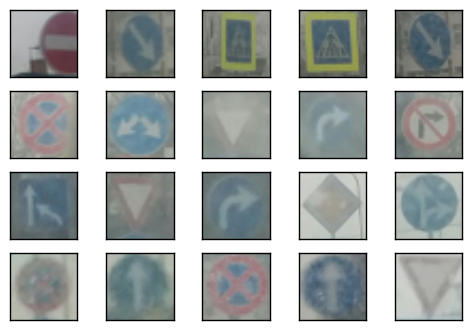

In [11]:
# Load 20 images from img folder with filenames t0.bmp - t19.bmp
# array my_images contains the loaded RGB images
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

my_images = np.zeros((20, 32, 32, 3),dtype=np.uint8)
fig = plt.figure()
for i in range(20):
    name = 'img/t'+str(i)+'.bmp'
    img = cv2.imread(name,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    my_images[i,:,:,:]=img
    sp = fig.add_subplot(4,5,i+1)
    sp.axes.get_xaxis().set_visible(False)
    sp.axes.get_yaxis().set_visible(False)
    sp.imshow(img)
fig.show()
print (my_images.shape)
conv_my_images = np.zeros((len(my_images), 32, 32, 3),dtype=np.uint8)
for i in range(len(my_images)):
    conv_my_images[i,:,:,:] = imgConv(my_images[i,:,:,:])
conv_my_labels = np.zeros((len(conv_my_images), n_classes),dtype=np.uint8)
print (conv_my_images.shape)
print (conv_my_labels.shape)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



/home/valtgun/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


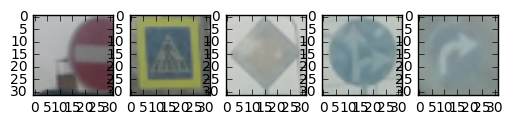

In [12]:
fig = plt.figure()
a=fig.add_subplot(1,5,1)
a.imshow(my_images[0,:,:,:])
b=fig.add_subplot(1,5,2)
b.imshow(my_images[3,:,:,:])
c=fig.add_subplot(1,5,3)
c.imshow(my_images[13,:,:,:])
d=fig.add_subplot(1,5,4)
d.imshow(my_images[14,:,:,:])
e=fig.add_subplot(1,5,5)
e.imshow(my_images[8,:,:,:])
fig.show()

**Answer:**
Above are the 5 chosen signs. Those signs were taken through the car window during moving car.
1. It could be hard to clasify as it is only part of the sign, however the shape which is visible is quite clear. Could be similar situations when part of the sign is obscured by traffic or environment (pole, etc). Correct label should be 17,No entry
2. Typical sign would be blue without yellow border. Yellow border is added to make it better visible for drivers, therefore it should be even more complex to determine. It is pedestrian crossing, but such sigh is not in the training dataset. It would be interesting what results trained network will give out.
3. 12,Priority road. However as the picture is taken on the bright backgrount it is harder to identify the yellow color in the middle. However it should be possible to determine sign by shape. 
4. 36,Go straight or right. Should be quite easy to identify.
5. 33,Turn right ahead. Image is quite blurred due to distance and dirty windshield. Shape however should be relatively easily identifiable.

In [13]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# Note, sometimes when loading tf gives error about variable already defined, then need to restart the kernel and execure without other load graph steps.
import tensorflow as tf
loader = tf.train.Saver()

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('model_3d_Fin.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    softmax, softmaxce, logits, predictions = sess.run([softmax, softmax_cross_entropy, y_conv, prediction],feed_dict={x: conv_my_images,y_: conv_my_labels, keep_prob: 1.0})

In [14]:
print ('Predictions:')
print (predictions)
print ('[17 38 NA NA 38 NA NA 13 33 NA NA 13 33 12 36 NA 35 NA 35 13]')
print ('Correct labels:')

Predictions:
[18 38 38 18 38 33 38 13 35  4 38 13 33 12 36 38 35 15 35 13]
[17 38 NA NA 38 NA NA 13 33 NA NA 13 33 12 36 NA 35 NA 35 13]
Correct labels:


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
In my set there was 12 images (7 unique), that had corresponsing data in the dataset.<br/>
For those 12 images, the error was 2 out of 12, or **16,6%**<br/>
Those errors were as follows:<br/>
**Image 0:** Cropped no entry sign, turned out as complex task for network. It means that in real application sign should be identified from multiple frames and probability should be checked, because from multiple frames there are larger chances that there will be no obstructions. As an alternative and probably for more critical signs, e.g. stop , yield, pedestrians, etc, the network should be also trained for partial images.<br/>
**Image 8:** Should have been identified as "Turn right ahead", but was identified as "Ahead only". THis is more critical error as sign was with relatively good shape. Checking the number of samples in the training set revealed that sign that was returned from prediction had almost twice as many samples. Therefore in order to avoid such issues, the number of samples in the data set should be made more equally distributed.<br/>

TopKV2(values=array([ 0.87410682,  0.06270495,  0.0310877 ,  0.02142218,  0.00852071], dtype=float32), indices=array([18, 12, 25, 11, 33], dtype=int32))


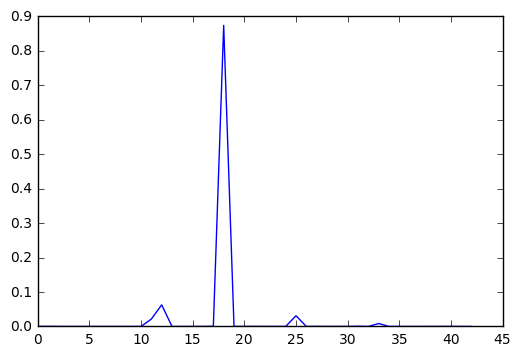

In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# Plot for sign 0
plt.plot(softmax[0])
import tensorflow as tf
with tf.Session() as sess:
    topk = sess.run(tf.nn.top_k((tf.constant(softmax[0])), k=5))
print (topk)

TopKV2(values=array([ 0.68338269,  0.20201774,  0.11378149], dtype=float32), indices=array([35, 13, 33], dtype=int32))


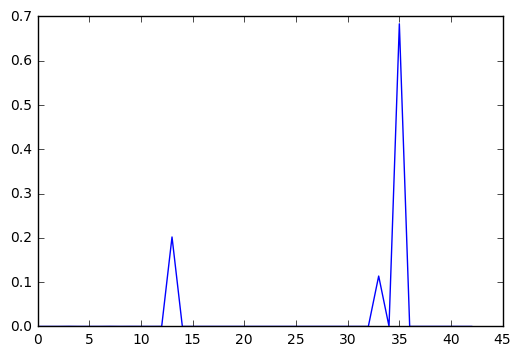

In [16]:
# Plot for sign 8
plt.plot(softmax[8])
import tensorflow as tf
with tf.Session() as sess:
    topk = sess.run(tf.nn.top_k((tf.constant(softmax[8])), k=3))
print (topk)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**<br/>
For the **sign 0, the correct result was not in top 5**. As stated above, the reason is that network does not recognize partially obstructed images.<br/><br/>
For the **sign 8, the correct result was at rank 3** with 0.11 probability (vs 0.68 and 0.20), as given the reason above this is probably due to fewer training data.<br/>

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Additional inspection code of the model and also additional runs besides the model above

In [17]:
# Read saved model and get list of tensor variable
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/inspect_checkpoint.py
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
reader = tf.train.NewCheckpointReader("/home/valtgun/CarND/CarND-Traffic-Signs/model_3d_Fin.ckpt")
reader.get_variable_to_shape_map()



{'Variable': [1, 1, 3, 3],
 'Variable/Adam': [1, 1, 3, 3],
 'Variable/Adam_1': [1, 1, 3, 3],
 'Variable_1': [3],
 'Variable_1/Adam': [3],
 'Variable_1/Adam_1': [3],
 'Variable_10': [3, 3, 64, 64],
 'Variable_10/Adam': [3, 3, 64, 64],
 'Variable_10/Adam_1': [3, 3, 64, 64],
 'Variable_11': [64],
 'Variable_11/Adam': [64],
 'Variable_11/Adam_1': [64],
 'Variable_12': [3, 3, 64, 64],
 'Variable_12/Adam': [3, 3, 64, 64],
 'Variable_12/Adam_1': [3, 3, 64, 64],
 'Variable_13': [64],
 'Variable_13/Adam': [64],
 'Variable_13/Adam_1': [64],
 'Variable_14': [12288, 512],
 'Variable_14/Adam': [12288, 512],
 'Variable_14/Adam_1': [12288, 512],
 'Variable_15': [512],
 'Variable_15/Adam': [512],
 'Variable_15/Adam_1': [512],
 'Variable_16': [512, 43],
 'Variable_16/Adam': [512, 43],
 'Variable_16/Adam_1': [512, 43],
 'Variable_17': [43],
 'Variable_17/Adam': [43],
 'Variable_17/Adam_1': [43],
 'Variable_2': [3, 3, 3, 32],
 'Variable_2/Adam': [3, 3, 3, 32],
 'Variable_2/Adam_1': [3, 3, 3, 32],
 'Varia

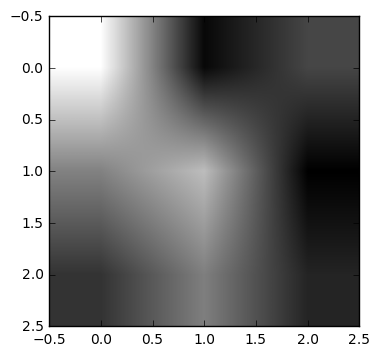

In [18]:
# Read saved model and inspect various tensor values
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/inspect_checkpoint.py
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
reader = tf.train.NewCheckpointReader("/home/valtgun/CarND/CarND-Traffic-Signs/model_3d_Fin.ckpt")
tens = reader.get_tensor("Variable_2")
#print (tens.shape)
#print (tens)
imgTest = tens[:,:,0,0]
plt.imshow(imgTest, cmap='gray')